In [101]:
#load package
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(factoextra)
    library(ggforce)
    library(pheatmap)
    library(fgsea)
    library(DESeq2)
    library(enrichplot)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(msigdbr)
    library(ggplot2)
    library(dplyr)
    library(EnhancedVolcano)
    library(openxlsx)
    library(patchwork)
}))

In [2]:
# Fig size setting
fig_size <- function (height, width) {
    options(repr.plot.height = height, 
            repr.plot.width = width)
}

### Load raw counts

In [4]:
#load raw counts 
data <- read.csv("../rowcount_niche_macrophage_geneonrow.csv", header = T, row.names = "gene_name")
data <- data[,sort(colnames(data))]
colSums(data)

CD11b.F4.80..BoMet_1  CD11b.F4.80..BoMet_2  CD11b.F4.80..BoMet_3 
             30332442              24278074              25603945 
CD11b.F4.80..Normal_1 CD11b.F4.80..Normal_2 CD11b.F4.80..Normal_3 
             15041967              18500621              20777176 
      Triple..BoMet_1       Triple..BoMet_2       Triple..BoMet_3 
             18565114              20952846              21579543 
     Triple..Normal_1      Triple..Normal_2      Triple..Normal_3 
             13687957              20187500              20492640

### Assign conditions 

In [5]:
# assign replicates to each condition to construct colData
condition <- c(rep("CD11b+D480+_Macrophage_BoMet", 3), 
               rep("CD11b+D480+_Macrophage_Normal", 3), 
               rep("CD163b+VCAM1+CCR3+_Macrophage_BoMet", 3), 
               rep("CD163b+VCAM1+CCR3+_Macrophage_Normal", 3))
my_colData <- as.data.frame(condition)
rownames(my_colData) <- colnames(data)
my_colData

,condition
,<chr>
CD11b.F4.80..BoMet_1,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..BoMet_2,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..BoMet_3,CD11b+D480+_Macrophage_BoMet
CD11b.F4.80..Normal_1,CD11b+D480+_Macrophage_Normal
CD11b.F4.80..Normal_2,CD11b+D480+_Macrophage_Normal
CD11b.F4.80..Normal_3,CD11b+D480+_Macrophage_Normal
Triple..BoMet_1,CD163b+VCAM1+CCR3+_Macrophage_BoMet
Triple..BoMet_2,CD163b+VCAM1+CCR3+_Macrophage_BoMet
Triple..BoMet_3,CD163b+VCAM1+CCR3+_Macrophage_BoMet


### Run DESeq2

In [6]:
#create a DESeq2 object
suppressMessages({
    dds <- DESeqDataSetFromMatrix(countData = round(data),
                              colData = my_colData,
                              design = ~condition)
    dds <- DESeq(dds)
    dds
    head(dds@assays@data$counts)
    })

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


,CD11b.F4.80..BoMet_1,CD11b.F4.80..BoMet_2,CD11b.F4.80..BoMet_3,CD11b.F4.80..Normal_1,CD11b.F4.80..Normal_2,CD11b.F4.80..Normal_3,Triple..BoMet_1,Triple..BoMet_2,Triple..BoMet_3,Triple..Normal_1,Triple..Normal_2,Triple..Normal_3
0610005C13Rik,18,111,0,2,0,0,71,0,1,42,1,102
0610009B22Rik,1,0,208,0,1,1,316,2,1,2,1,351
0610009E02Rik,273,791,355,0,262,833,411,193,473,0,160,0
0610010F05Rik,1250,1230,617,94,625,32,1316,1573,351,1225,1773,783
0610010K14Rik,204,27,178,46,2,186,0,16,0,0,0,1
0610012D04Rik,71,0,0,200,0,1,0,306,0,0,0,1


In [7]:
res1 <- results(dds, contrast = c("condition", "CD163b+VCAM1+CCR3+_Macrophage_BoMet", "CD163b+VCAM1+CCR3+_Macrophage_Normal")) 
res2 <- results(dds, contrast = c("condition", "CD163b+VCAM1+CCR3+_Macrophage_BoMet", "CD11b+D480+_Macrophage_BoMet")) 
res3 <- results(dds, contrast = c("condition", "CD163b+VCAM1+CCR3+_Macrophage_Normal", "CD11b+D480+_Macrophage_Normal")) 
res4 <- results(dds, contrast = c("condition", "CD11b+D480+_Macrophage_BoMet", "CD11b+D480+_Macrophage_Normal"))

In [8]:
titles = c(
    "CD163b+VCAM1+CCR3+_Macrophage_BoMet \nvs CD163b+VCAM1+CCR3+_Macrophage_Normal",
    "CD163b+VCAM1+CCR3+_Macrophage_BoMet \nvs CD11b+D480+_Macrophage_BoMet",
    "CD163b+VCAM1+CCR3+_Macrophage_Normal \nvs CD11b+D480+_Macrophage_Normal",
    "CD11b+D480+_Macrophage_BoMet \nvs CD11b+D480+_Macrophage_Normal"
)

In [9]:
results = list(
    "1" = res1 %>% data.frame,
    "2" = res2 %>% data.frame,
    "3" = res3 %>% data.frame,
    "4" = res4 %>% data.frame
)

### Load known cytokines

In [11]:
cyto_df = read.xlsx("../Full_cytokines_growth_factor_list.xlsx")

In [15]:
cyto_ligands = cyto_df$Ligand %>% unique

### Plot

In [107]:
plot_basic_volcano = function(res_df2, cytokines, title, fc_cutoff, p_cutoff){
    fig_size(7,9)
    all_cytokines = res_df2 %>% filter(Gene %in% cyto_ligands) %>% pull(Gene)
    
    # Debug: Check what genes are being labeled
    cytokines_to_label = res_df2 %>% filter(Gene %in% cytokines) %>% pull(Gene)
    print(paste("Genes to be labeled:", paste(cytokines_to_label, collapse = ", ")))
    print(paste("Number of genes to label:", length(cytokines_to_label)))
    
    p =  ggplot() +
      # non‑cytokines colored by significance
      geom_point(
        data = filter(res_df2, !Gene %in% cytokines),
        aes(x = log2FoldChange, y = negLog10P, color = Significance),
        alpha = 0.6
      ) +
      # cytokines always blue
      geom_point(
        data = filter(res_df2, Gene %in% all_cytokines),
        aes(x = log2FoldChange, y = negLog10P),
        color = "blue",
        size  = 2
      ) +
      scale_color_manual(
        values = c(
          "Non‑significant" = "grey70",
          "Significant"     = "red"
        )
      ) +
      # arrow labels for the cytokines - IMPROVED VERSION
      geom_text_repel(
        data = filter(res_df2, Gene %in% cytokines),
        aes(x = log2FoldChange, y = negLog10P, label = Gene),
        color = "blue",
        fontface = "italic",
        size = 6,  # Reduced from 6 for better appearance
        
        # AGGRESSIVE parameters to push text FAR from points:
        box.padding = 1.5,        # Much larger padding around text boxes
        point.padding = 0,      # Much larger padding around points
        min.segment.length = 0,   # Always show segments
        
        # Very strong forces:
        force = 15,               # Much stronger repulsion between labels
        force_pull = 0.1,         # Weaker pull toward original position
        
        # Strong nudging to push labels away:
        nudge_x = 0,              
        nudge_y = 1,              # Push labels much higher
        
        # More iterations for better placement:
        max.iter = 50000,         
        
        # Direction - try pushing labels in specific directions:
        direction = "both",       # Allow labels in all directions
        
        # Seed for reproducible label placement:
        seed = 42,
        
        # Arrow styling:
        arrow = arrow(length = unit(0.01, "npc"), type = "closed", angle = 15),
        segment.size = 0.8,
        segment.color = "blue",
        
        # Overlap control:
        max.overlaps = Inf
      ) +
      labs(
        x     = "log2 Fold‑Change",
        y     = "-log10 (p‑value)",
        color = ""
      ) +
      guides(
        color = guide_legend(
          override.aes = list(size = 6)  # increase legend point size
        )
      ) +
      geom_vline(xintercept = c(-fc_cutoff, fc_cutoff), linetype = "dotted", color = "black",linewidth=0.7) +
      geom_hline(yintercept = -log10(p_cutoff), linetype = "dotted", color = "black",linewidth=0.7) +
      theme_minimal() +
      theme(
        legend.text = element_text(size = 14),
        legend.key.size = unit(1, "lines"),
        axis.text  = element_text(size = 14),  
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 15, face = "bold")
      ) + ggtitle(title)
    
    p
}

In [108]:
plots = list()
for(i in 1:4){
    print(i)
    
    # filter out any rows with NA in padj, pvalue or log2FC, then compute stats
    res_df = results[[i]]
    res_df$Gene = rownames(res_df)
    fc_cutoff <- 5    # log2 fold‑change cutoff (e.g. 1 = 2‑fold)
    p_cutoff  <- 0.05
    # res_df2 <- res_df %>%
    #   filter(!is.na(padj) & !is.na(pvalue) & !is.na(log2FoldChange)) %>%
    #   mutate(
    #     negLog10P    = -log10(pvalue),
    #     Significance = ifelse(padj < 0.05, "Significant", "Non‑significant")
    #   )
    # filter cytokines 
    filtered_res <- res_df %>%
        filter(Gene %in% cyto_ligands, padj < p_cutoff)
    top_genes <- filtered_res %>% arrange(desc(log2FoldChange)) %>% slice_head(n = 10)
    bottom_genes <- filtered_res %>% arrange(log2FoldChange) %>% slice_head(n = 10)
    combined <- bind_rows(top_genes, bottom_genes) %>%
        group_by(Gene) %>%
        slice_max(abs(log2FoldChange), n = 1, with_ties = FALSE) %>%
        ungroup() %>%
        arrange(desc(log2FoldChange))  # Ensure order after deduplication
    
    res_df2 <- res_df %>%
      filter(!is.na(padj), !is.na(pvalue), !is.na(log2FoldChange)) %>%
      mutate(
        negLog10P    = -log10(padj),
        Significance = case_when(
          padj < p_cutoff & abs(log2FoldChange) >= fc_cutoff ~ "Significant",
          TRUE                                               ~ "Non‑significant"
        )
      )
    
    # your cytokine list
    cytokines = combined %>% pull(Gene)
    p = plot_basic_volcano(res_df2, cytokines, titles[[i]], fc_cutoff, p_cutoff)
    plots[[i]] = p
    #ggsave(file=paste0('volcano_plots/compare_',i,'_with_fc_cutoff_',fc_cutoff,'.pdf'), plot=p, height=7,width=9)
    
}

[1] 1
[1] "Genes to be labeled: Ccl2, Cxcl10, Hgf, Igf1, Tgfb1"
[1] "Number of genes to label: 5"
[1] 2
[1] "Genes to be labeled: Cxcl12, Fgf1, Igf1, Tnfsf10"
[1] "Number of genes to label: 4"
[1] 3
[1] "Genes to be labeled: Ccl6, Cxcl16, Fgf1, Hgf, Igf1, Il18, Il1b, Il1f9, Il1rn, Tnfsf10"
[1] "Number of genes to label: 10"
[1] 4
[1] "Genes to be labeled: Ccl2, Ccl6, Cxcl12"
[1] "Number of genes to label: 3"


In [109]:
combined_plot <- plots[[1]] + plots[[2]] + plots[[3]] + plots[[4]] + 
  plot_layout(ncol = 2)

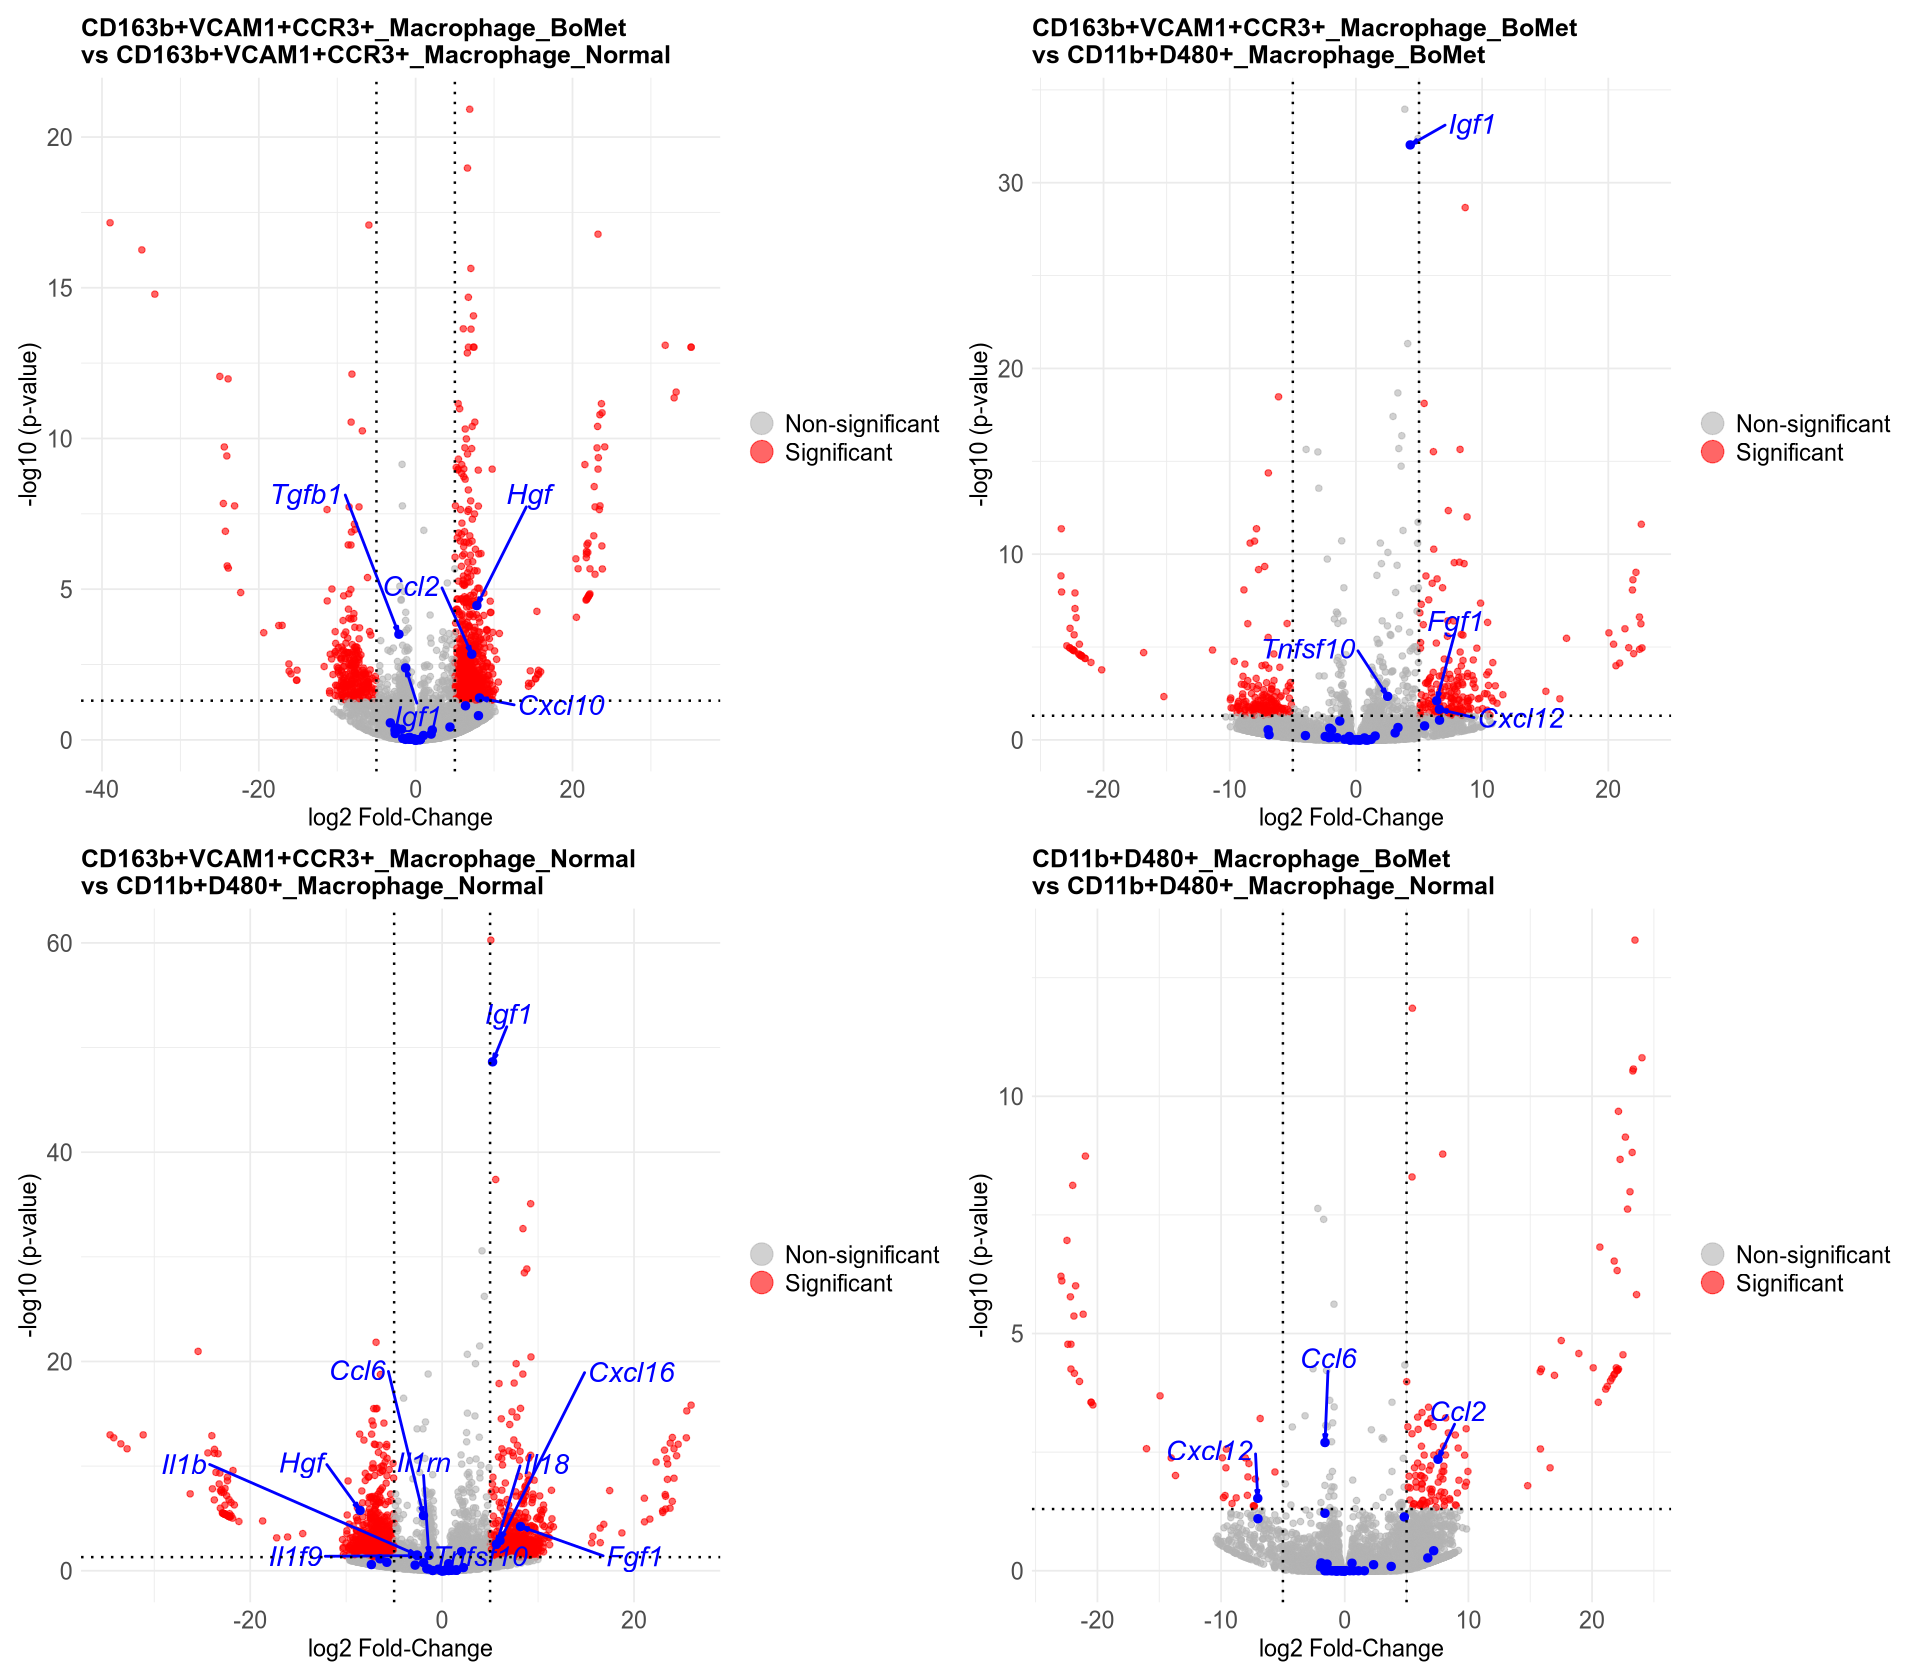

In [110]:
fig_size(14,16)
combined_plot